In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from table_reader import TableReader
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In order to connect to our database, follow the steps below. Let Seth (seth@sethpeterson.net) know if you need the database connection url. 

    1. Create a file called config.json in the project root.
    2. Inside, config.json should look like this:
    {
        "database_url":"database_url_goes_here"
    }

TableReader's other vector methods are geodata_vector() and reviews_vector(). 

Read in data

In [125]:
tr = TableReader()
prop = tr.properties_vector(include_amenitites=True)
geo = tr.geodata_vector()
ratings = tr.reviews_vector()[['listingID','num_reviews', 'rating']]
tr.close() #Be sure to call close() when you're done so it terminates the connection to the DB.

Merge data frames 

In [126]:
#merge our properties, geo, and rating df on listingID
df = pd.merge(geo, prop, on='listingID')
df = pd.merge(df, ratings, on='listingID', how='left')

In [127]:
df = df[df['num_reviews'] > 10]
df.dropna(subset=['zipcode'], inplace=True)
df.dropna(axis = 0, how ='any', inplace=True) 

In [128]:
df.head()

,listingID,zipcode,latitude,longitude,"Brightwood Park, Crestwood, Petworth","Brookland, Brentwood, Langdon","Capitol Hill, Lincoln Park","Capitol View, Marshall Heights, Benning Heights","Cathedral Heights, McLean Gardens, Glover Park","Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace",...,Bed linens,Iron,Carbon monoxide detector,Free parking on premises,Pets allowed,Lockbox,Dryer,Extra pillows and blankets,num_reviews,rating
1,3344,20005.0,38.90126,-77.02857,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,11,100.0
2,3662,20020.0,38.86193,-76.98963,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,36,94.0
3,3686,20020.0,38.86314,-76.98836,0,0,0,0,0,0,...,1,0,1,0,0,0,1,1,69,91.0
5,4197,20003.0,38.88791,-76.99668,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,39,97.0
6,4529,20019.0,38.90645,-76.94305,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,99,93.0


In [129]:
features = df[df.columns.drop(['price', 'listingID'])]
label = df['price']

## Feature Selection

In [130]:
model = ElasticNet()
esfm = SelectFromModel(model)
esfm.fit(features, label)
print(list(features.iloc[:, esfm.get_support(indices=True)]))

['Capitol Hill, Lincoln Park', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Georgetown, Burleith/Hillandale', 'accomodates', 'bathrooms', 'bedrooms', 'beds', 'Guest suite', 'Entire home/apt', 'Private room', 'Shared room', 'First aid kit', 'Self check-in', 'TV', '24-hour check-in', 'Indoor fireplace', 'Free street parking', 'Elevator', 'Cable TV', 'Family/kid friendly', 'Gym', 'Paid parking off premises', 'Washer', 'Lock on bedroom door', 'Internet', 'Free parking on premises', 'Dryer', 'rating']


In [131]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['zipcode', 'Capitol Hill, Lincoln Park', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Georgetown, Burleith/Hillandale', 'accomodates', 'bathrooms', 'bedrooms', 'Entire home/apt', '24-hour check-in', 'Indoor fireplace', 'Free street parking', 'Elevator', 'Cable TV', 'Family/kid friendly', 'Gym', 'Lock on bedroom door', 'Internet', 'Free parking on premises', 'Dryer', 'num_reviews', 'rating']


In [132]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['latitude', 'longitude', 'Capitol Hill, Lincoln Park', 'Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace', 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Edgewood, Bloomingdale, Truxton Circle, Eckington', 'Georgetown, Burleith/Hillandale', 'Howard University, Le Droit Park, Cardozo/Shaw', 'Ivy City, Arboretum, Trinidad, Carver Langston', 'Kalorama Heights, Adams Morgan, Lanier Heights', 'Near Southeast, Navy Yard', 'North Cleveland Park, Forest Hills, Van Ness', 'Shaw, Logan Circle', 'Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point', 'Union Station, Stanton Park, Kingman Park', 'West End, Foggy Bottom, GWU', 'bathrooms', 'bedrooms', 'Apartment', 'Guest suite', 'Serviced apartment', 'Entire home/apt', 'Shared room']


In [133]:
elastic_data = df[list(features.iloc[:, esfm.get_support(indices=True)])]

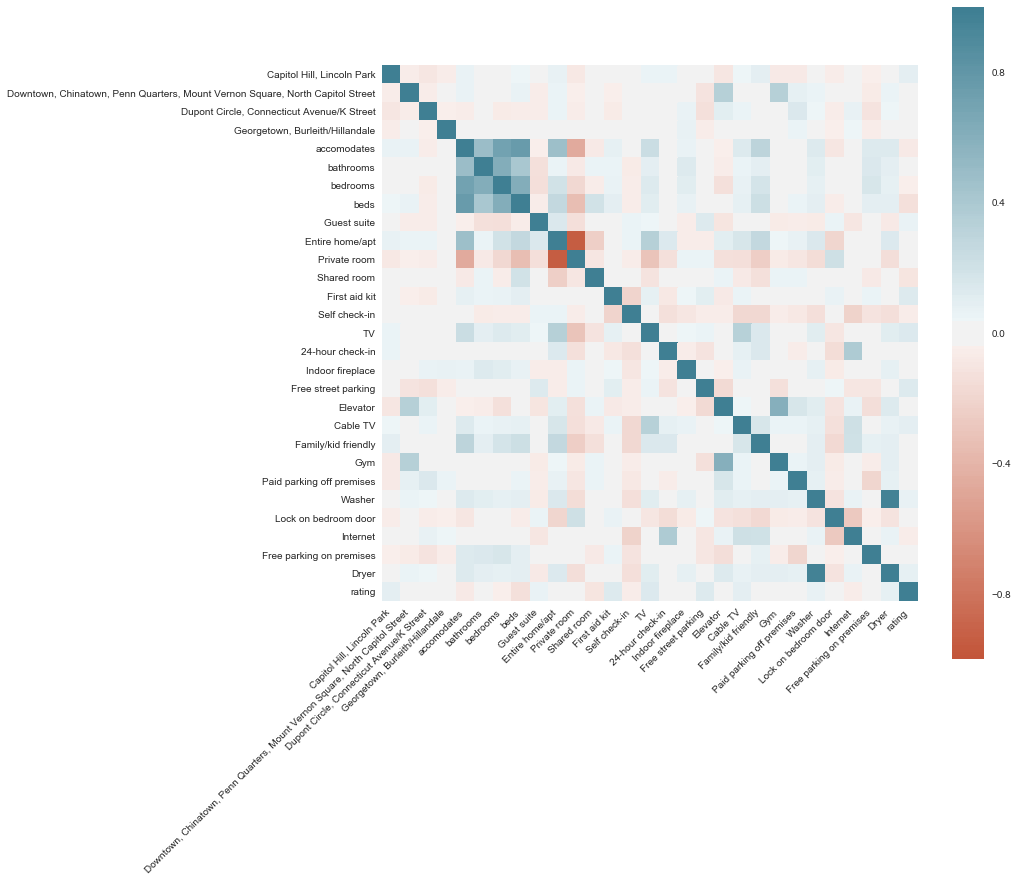

In [134]:
corr = elastic_data.corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('feature_correlation_heatmap.png', dpi=100)

Chi-squared (chi²) statistical test for non-negative features to select 20 of the best features

In [135]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#drop geo data in the feature selection because Chi2 only works for non-negative features
featureswithoutgeo = features[features.columns.drop(['longitude'])]

#apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(featureswithoutgeo,label)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(featureswithoutgeo.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

                                                 Specs         Score
104                                        num_reviews  27183.566869
30                                         accomodates   2473.582634
42                                         Shared room   2128.129306
33                                                beds   1618.942310
41                                        Private room   1342.079583
38                                  Serviced apartment   1282.085411
32                                            bedrooms   1052.020329
10   Downtown, Chinatown, Penn Quarters, Mount Vern...    827.206153
5      Capitol View, Marshall Heights, Benning Heights    771.429540
65                                                Pool    671.943591
84                                                 Gym    660.933201
40                                     Entire home/apt    650.559290
28                         West End, Foggy Bottom, GWU    630.330009
43                               W

Feature Importance

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 20 features for the dataset.

[0.03225098 0.05163694 0.0520089  0.00614836 0.00350754 0.00836978
 0.00105    0.00198976 0.00156589 0.01053012 0.00123059 0.00312907
 0.00613437 0.01078885 0.00189875 0.00410142 0.00584316 0.00461741
 0.00380768 0.00189039 0.00101539 0.00064031 0.00195148 0.00836167
 0.00215646 0.00100989 0.00260164 0.00218634 0.00997268 0.00285048
 0.00163465 0.03707457 0.01792531 0.02254775 0.02955554 0.01096552
 0.00628399 0.00420404 0.0093241  0.00124739 0.00945896 0.00452698
 0.00365299 0.00264912 0.00352398 0.02272202 0.0042896  0.00508714
 0.00161539 0.00761512 0.00217887 0.00192094 0.01265654 0.0073057
 0.00192968 0.00169815 0.00280698 0.00548768 0.00305263 0.01092811
 0.00077238 0.00409946 0.01325349 0.02188463 0.00787086 0.00300432
 0.00430307 0.01326809 0.00045352 0.00571033 0.01914869 0.0032758
 0.00200822 0.01606709 0.01120274 0.00367163 0.00063493 0.00344013
 0.01857604 0.005017   0.01366826 0.00151463 0.00787693 0.01561364
 0.02032434 0.0054212  0.01062072 0.00235656 0.01607202 0.001307

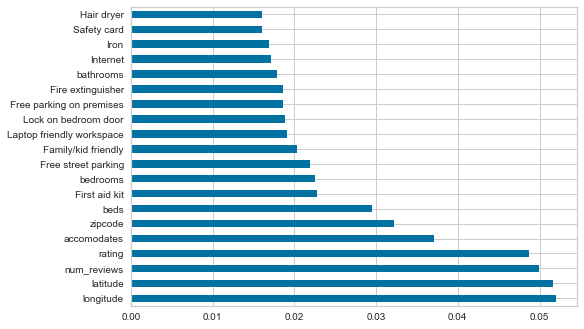

In [136]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(features,label)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## Model Evaluation with top 20 features

In [137]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [138]:
Top20Features = [
    'latitude',
    'num_reviews',
    'longitude',
    'rating',
    'accomodates',
    'zipcode',
    'beds',
    'First aid kit',
    'bedrooms',
    'Free street parking',
    'Internet',
    'Lock on bedroom door',
    'Family/kid friendly',
    'Free parking on premises',
    'Iron',                         
    'bathrooms',                   
    'Fire extinguisher',          
    'Laptop friendly workspace',    
    'Hair dryer',         
    'Cable TV',
]

X_train_featureSelection, X_test_featureSelection, y_train_featureSelection, y_test_featureSelection = tts(features[Top20Features], label, test_size=0.2)

regr = LinearRegression()
regr.fit(X_train_featureSelection,y_train_featureSelection)
print(mean_squared_error(y_test_featureSelection, regr.predict(X_test_featureSelection)))
print(regr.score(X_test_featureSelection,y_test_featureSelection))

1924.9501600929455
0.5622287054713371


## Remove features with high correlations
Quick Model Comparison Between Models with highly correlated features vs without

In [139]:
featuresWithoutHighCorrFeature = features[features.columns.drop(['bedrooms', 'beds', 'Private room','Elevator','Dryer'])]

In [140]:
#Split without highly correlated features
X_train_featureSelection, X_test_featureSelection, y_train_featureSelection, y_test_featureSelection = tts(featuresWithoutHighCorrFeature, label, test_size=0.2)
#Split with all features
X_train, X_test, y_train, y_test = tts(features, label, test_size=0.2)

In [141]:
regr = LinearRegression()
regr.fit(X_train_featureSelection,y_train_featureSelection)
print('The mean squared error for model without highly correlated feature: ' + str(mean_squared_error(y_test_featureSelection, regr.predict(X_test_featureSelection))))
print('The r2 for model without highly correlated feature: ' + str(regr.score(X_test_featureSelection, y_test_featureSelection)))

regr = LinearRegression()
regr.fit(X_train,y_train)
print('The mean squared error for model with all features: ' + str(mean_squared_error(y_test, regr.predict(X_test))))
print('The r2 for model with all featuers: '+ str(regr.score(X_test,y_test)))

The mean squared error for model without highly correlated feature: 1854.0422791469061
The r2 for model without highly correlated feature: 0.6059942484421099
The mean squared error for model with all features: 1643.5873185849453
The r2 for model with all featuers: 0.6576870753805374


# Model Selection

The following models are from Georgetown Data Analytics (CCPE), under the machine learning notebook: https://github.com/georgetown-analytics/machine-learning/tree/master/notebook

In [142]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = tts(featuresWithoutHighCorrFeature, label, test_size=0.2)

Linear Regression

In [143]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print(mean_squared_error(y_test, lr.predict(X_test)))
print(lr.score(X_test,y_test))

1714.9200073624545
0.6164926602711998


Lasso

In [144]:
lasso_model = Lasso()
lasso_model.fit(X_train,y_train)
print('Lasso mean squared error: ' + str(mean_squared_error(y_test, lasso_model.predict(X_test))))
print('Lasso R^2: '+ str(lasso_model.score(X_test, y_test)))

Lasso mean squared error: 2050.317740071682
Lasso R^2: 0.5414877086290436


Ridge

In [145]:
ridge_model = Ridge()
ridge_model.fit(X_train,y_train)
print('Ridge mean squared error: '+ str(mean_squared_error(y_test, ridge_model.predict(X_test))))
print('Ridge R^2: '+ str(ridge_model.score(X_test, y_test)))

Ridge mean squared error: 1735.8706262946132
Ridge R^2: 0.6118074760656103


# Hyperparameter tuning

Ridge

In [146]:
import numpy as np

# try 200 different alphas between -10 and -2
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

model_ridge = RidgeCV(alphas=alphas)
model_ridge.fit(X_train, y_train)

#which alpha did it pick?
print(model_ridge.alpha_)


0.01


In [147]:
ridge_a = Ridge(alpha=0.01)
ridge_a.fit(X_train, y_train)
print('Ridge mean squared error: '+ str(mean_squared_error(y_test, ridge_a.predict(X_test))))
print('Ridge R^2: '+ str(ridge_a.score(X_test, y_test)))

Ridge mean squared error: 1715.40882106278
Ridge R^2: 0.6163833469265364


Lasso

In [148]:
from sklearn.model_selection import GridSearchCV

lasso = Lasso(random_state=0)

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_params = [{'alpha': alphas}]
n_folds = 12

grid = GridSearchCV(
    lasso, tuned_params, cv=n_folds
)

grid.fit(X_train, y_train)
print(grid.best_estimator_)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)


In [149]:
lasso_a = Lasso(alpha=0.01)
lasso_a.fit(X_train, y_train)
print('Lasso mean squared error: ' + str(mean_squared_error(y_test, lasso_a.predict(X_test))))
print('Lasso R^2: '+ str(lasso_a.score(X_test, y_test)))

Lasso mean squared error: 1722.2564714773532
Lasso R^2: 0.6148520077488422


# Model Evaluation

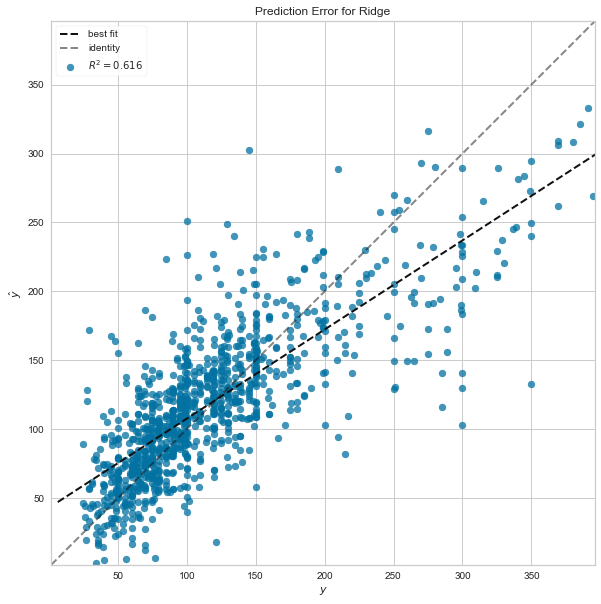

In [150]:
from yellowbrick.regressor import PredictionError

model_r = Ridge(alpha=0.01)
visualizer = PredictionError(model_r, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

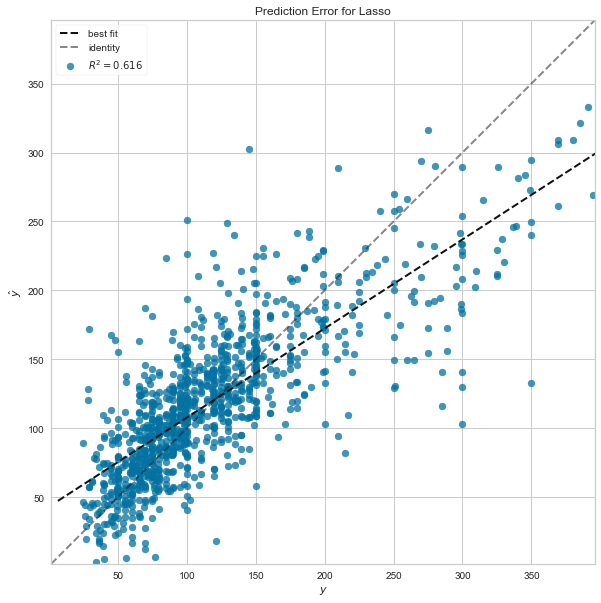

In [151]:
model_l = Lasso(alpha=0.001)
visualizer = PredictionError(model_l, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Mean cv score: 0.5934010340519482


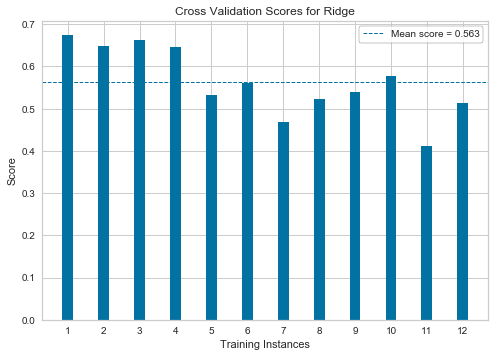

In [152]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
from statistics import mean
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ridge_a, featuresWithoutHighCorrFeature, label, cv=12)          

print('Mean cv score: '+ str(mean(scores)))

cv = StratifiedKFold(n_splits=12, random_state=42)
visualizer_ridge = CVScores(ridge_a, cv=cv, scoring='r2')

visualizer_ridge.fit(featuresWithoutHighCorrFeature.values, label.values)        # Fit the data to the visualizer
visualizer_ridge.poof()           # Draw/show/poof the data

Mean cv score: 0.5934091728427813


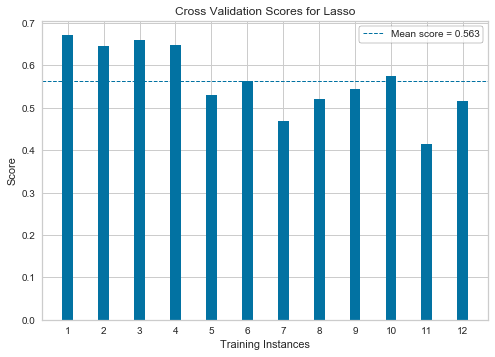

In [153]:
scores = cross_val_score(lasso_a, featuresWithoutHighCorrFeature, label, cv=12)          

print('Mean cv score: '+ str(mean(scores)))

cv = StratifiedKFold(n_splits=12, random_state=42)
visualizer_lasso = CVScores(lasso_a, cv=cv, scoring='r2')

visualizer_lasso.fit(featuresWithoutHighCorrFeature.values, label.values)        # Fit the data to the visualizer
visualizer_lasso.poof()           # Draw/show/poof the data

Mean cv score: 0.593377444671459


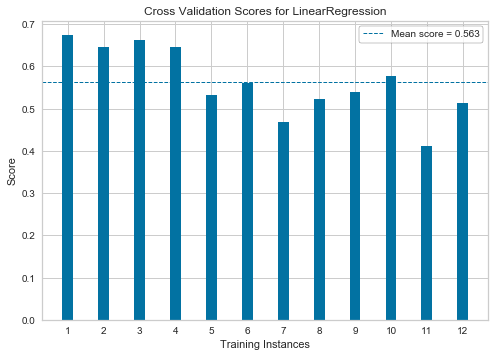

In [154]:
scores = cross_val_score(lr, featuresWithoutHighCorrFeature, label, cv=12)          

print('Mean cv score: '+ str(mean(scores)))

cv = StratifiedKFold(n_splits=12, random_state=42)
visualizer_lr = CVScores(lr, cv=cv, scoring='r2')

visualizer_lr.fit(featuresWithoutHighCorrFeature.values, label.values)        # Fit the data to the visualizer
visualizer_lr.poof()           # Draw/show/poof the data

In [155]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

def func(x): return np.log(x)
def inverse_func(x): return np.exp(x)

featuresWithoutHighCorrFeature = features[features.columns.drop(['bedrooms', 'beds', 'Private room','Elevator','Dryer','latitude','longitude'])]

transformer = QuantileTransformer(output_distribution='normal')
regressor = LinearRegression()
regr = TransformedTargetRegressor(regressor=regressor, func=func,inverse_func=inverse_func)
X_train, X_test, y_train, y_test = tts(featuresWithoutHighCorrFeature, label, test_size=0.2)

X_train.describe()

,zipcode,"Brightwood Park, Crestwood, Petworth","Brookland, Brentwood, Langdon","Capitol Hill, Lincoln Park","Capitol View, Marshall Heights, Benning Heights","Cathedral Heights, McLean Gardens, Glover Park","Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","Congress Heights, Bellevue, Washington Highlands","Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street",...,Internet,Bed linens,Iron,Carbon monoxide detector,Free parking on premises,Pets allowed,Lockbox,Extra pillows and blankets,num_reviews,rating
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,...,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000
mean,20010.374057,0.049057,0.020991,0.098113,0.007547,0.012972,0.011557,0.098349,0.008255,0.033019,...,0.398349,0.037500,0.596462,0.792925,0.277358,0.138915,0.081604,0.008962,67.331368,95.470283
std,48.698631,0.216012,0.143369,0.297503,0.086556,0.113166,0.106891,0.297821,0.090490,0.178707,...,0.489616,0.190006,0.490665,0.405258,0.447748,0.345899,0.273792,0.094255,69.547856,3.799041
min,20001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,85.000000
25%,20002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,94.000000
50%,20007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,42.000000,96.000000
75%,20011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,88.000000,98.000000
max,22202.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,728.000000,100.000000


In [156]:
regr.fit(X_train, y_train) 
TransformedTargetRegressor(...)

print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

raw_target_regr = LinearRegression().fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))

R2 score: 0.63
R2 score: 0.61
